# Import Event Log

In [1]:
import pandas as pd
import numpy as np
import pm4py
from pm4py.objects.conversion.log import converter as log_converter

if __name__ == "__main__":
    # Read the CSV file
    dataframe_log = pd.read_csv('../../data/logs/model_A.csv', sep=',')

    # Drop the first column without knowing its name
    dataframe_log = dataframe_log.drop(dataframe_log.columns[0], axis=1)

    # Format the dataframe
    dataframe_log = pm4py.format_dataframe(
        dataframe_log,
        case_id='case:concept:name',
        activity_key='concept:name',
        timestamp_key='time:timestamp'
    )

    # Convert the dataframe to event log
    log = log_converter.apply(dataframe_log)

/var/folders/s_/ch_w_j2d0sqf6dbdc0_224m40000gq/T/ipykernel_2074/4001343475.py:14: DeprecatedWarning: format_dataframe is deprecated as of 2.3.0 and will be removed in 3.0.0. the format_dataframe function does not need application anymore.
  dataframe_log = pm4py.format_dataframe(


# Preprocessing

In [2]:
from sklearn.preprocessing import MultiLabelBinarizer

# Step 1: One-Hot Encoding of Activities
mlb = MultiLabelBinarizer()
traces = dataframe_log.groupby('@@case_index')['concept:name'].apply(list)
one_hot_encoded = mlb.fit_transform(traces)

In [3]:
one_hot_encoding = np.array(one_hot_encoded.tolist())

# Input Traces

In [4]:
# Step 2: Group by case_index and concatenate the activities to form traces
dataframe_log['trace'] = dataframe_log.groupby('@@case_index')['concept:name'].transform(lambda x: ', '.join(x))

# Step 3: Count occurrences of each unique trace
trace_counts = dataframe_log['trace'].value_counts()

# Step 4: Convert to DataFrame and sort by occurrences
trace_counts_df = trace_counts.reset_index()
trace_counts_df.columns = ['Trace', 'Count']
trace_counts_df = trace_counts_df.sort_values(by='Count', ascending=False)


In [5]:
trace1 = ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_DECLINED']
trace2 = ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_ACCEPTED', 'A_FINALIZED', 'A_CANCELLED']
trace3 = ['A_SUBMITTED', 'A_PARTLYSUBMITTED', 'A_PREACCEPTED', 'A_CANCELLED']

In [6]:
grouped = dataframe_log.groupby('@@case_index')['concept:name'].apply(list).reset_index(name='trace')

In [7]:
def is_happy_trace(row_trace):
    predefined_traces = [trace1, trace2, trace3]
    for trace in predefined_traces:
        if row_trace == trace:
            return 1
    return 0

In [8]:
grouped['happy'] = grouped['trace'].apply(is_happy_trace)
grouped

,@@case_index,trace,happy
0,0,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0
1,1,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0
2,2,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0
3,3,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1
4,4,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1
...,...,...,...
13082,13082,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0
13083,13083,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1
13084,13084,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1
13085,13085,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0


In [9]:
# Get indices of the happy traces in the results dataframe
happy_trace_indices = grouped[grouped['happy'] == 1].index.tolist()

# Extract the corresponding coordinates from the trace_representations array
happy_trace_coordinates = one_hot_encoding[happy_trace_indices]

# Extract unique coordinates
unique_happy_trace_coordinates = np.unique(happy_trace_coordinates, axis=0)

# Assuming the size of unique_happy_trace_coordinates is 3
#happy_trace1, happy_trace2, happy_trace3 = unique_happy_trace_coordinates
happy_trace1, happy_trace2, happy_trace3 = unique_happy_trace_coordinates

# Distance Measurement

In [10]:
from scipy.spatial.distance import euclidean

# Calculate the distances to each of the happy traces for every trace representation
distances_to_happy_traces = []

for trace_representation in one_hot_encoding:
    distances = [
        euclidean(trace_representation, happy_trace1),
        euclidean(trace_representation, happy_trace2),
        euclidean(trace_representation, happy_trace3)
    ]
    distances_to_happy_traces.append(distances)

# Calculate the average distance to the happy traces for each trace representation
avg_distances = [np.mean(distances) for distances in distances_to_happy_traces]

# Save the distances in a variable
avg_distances_var = np.array(avg_distances)

# Ground Truth

In [11]:
def generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking):
    from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments
    from pm4py.algo.conformance.alignments.petri_net import variants
    from pm4py.objects.petri_net.utils import align_utils
    max_events=0
    for trace in log:
        counter=0
        for event in trace:
            counter+=1
        if counter > max_events:
            max_events=counter
    parameters={}
    parameters[alignments.Variants.VERSION_STATE_EQUATION_A_STAR.value.Parameters.PARAM_SYNC_COST_FUNCTION] = list(map(lambda i: .1*i, range(max_events*2)))
    parameters[alignments.Variants.VERSION_STATE_EQUATION_A_STAR.value.Parameters.PARAM_TRACE_COST_FUNCTION]=list(map(lambda i: align_utils.STD_MODEL_LOG_MOVE_COST-.1*i, range(max_events*2)))
    aligned_traces = alignments.apply_log(log, net, initial_marking, final_marking, variant=variants.state_equation_a_star, parameters=parameters)
    return aligned_traces

In [12]:
import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("../../data/model/Model_A_corrected.bpmn")

# 3. Convert the BPMN to a Petri net
net, initial_marking, final_marking = pm4py.convert_to_petri_net(bpmn_graph)

aligned_traces = generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking)

aligning log, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

In [13]:
def extract_conformance_status_by_fitness(aligned_traces):
    conformance_status = []
    for alignment in aligned_traces:
        fitness = alignment['fitness']
        # If the fitness is 1.0, the trace is conforming
        if fitness == 1.0:
            conformance_status.append(1)
        else:
            conformance_status.append(0)
    return conformance_status

# Get the conformance status list from the aligned traces
conformance = extract_conformance_status_by_fitness(aligned_traces)

# Results overview

In [14]:
results = pd.DataFrame(grouped['trace'])

conformity_array = conformance
results['conform'] = conformity_array

results['distance'] = avg_distances_var

results

,trace,conform,distance
0,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0,2.365080
1,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",1,2.365080
2,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",1,2.365080
3,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1,1.322706
4,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1,1.322706
...,...,...,...
13082,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0,1.577350
13083,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1,1.322706
13084,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_DECLINED]",1,1.322706
13085,"[A_SUBMITTED, A_PARTLYSUBMITTED, A_PREACCEPTED...",0,1.577350


# (Check if input traces = conform)

In [15]:
check = pd.DataFrame(results['conform'])
check['happy'] = grouped['happy']

In [16]:
# Check if there is any row where happy = 1 but conform = 0
condition = (check['happy'] == 1) & (check['conform'] == 0)
result = check[condition]

# Check if the condition is met and print the result
if not result.empty:
    print("There is at least one non conform input trace")
    print(result)
else:
    print("Input Traces conform")


Input Traces conform


# Evaluation

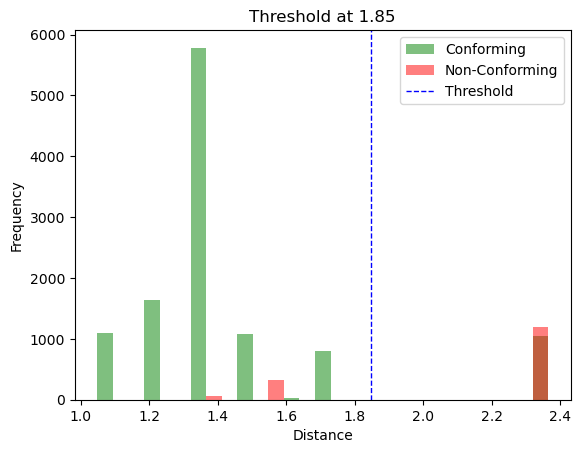

In [17]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans

# Filter the DataFrame into conforming and non-conforming subsets
conforming_distances = results[results['conform'] == 1]['distance']
non_conforming_distances = results[results['conform'] == 0]['distance']

# Determine common bin edges
min_distance = min(results['distance'])
max_distance = max(results['distance'])
bin_edges = np.linspace(min_distance, max_distance, num=30)

# Combine the data and reshape for k-means
all_distances = results['distance']
all_distances = np.array(all_distances)
all_distances_reshaped = all_distances.reshape(-1, 1)

# Apply k-means clustering
kmeans = KMeans(n_clusters=2, random_state=0).fit(all_distances_reshaped)
kmeans_labels = kmeans.labels_

# Find the threshold as the average of the two cluster centers
threshold_value = np.mean(kmeans.cluster_centers_)

# Plot histograms and the threshold
plt.hist(conforming_distances, bins=bin_edges, alpha=0.5, label='Conforming', color='green')
plt.hist(non_conforming_distances, bins=bin_edges, alpha=0.5, label='Non-Conforming', color='red')
plt.axvline(threshold_value, color='blue', linestyle='dashed', linewidth=1, label='Threshold')
plt.xlabel('Distance')
plt.ylabel('Frequency')
plt.legend(loc='upper right')
plt.title(f'Threshold at {threshold_value:.2f}')

plt.savefig('Model_A_Threshold.png', dpi=300, bbox_inches='tight')

plt.show()

In [18]:
true_positive = np.sum(results[results['conform'] == 1]['distance'] < threshold_value)
true_negative = np.sum(results[results['conform'] == 0]['distance'] > threshold_value)
false_positive = np.sum(results[results['conform'] == 0]['distance'] < threshold_value)
false_negative = np.sum(results[results['conform'] == 1]['distance'] > threshold_value)

In [19]:
# Calculate accuracy
accuracy = (true_positive + true_negative) / (true_positive + true_negative + false_positive + false_negative)
print(f"Accuracy: {accuracy:.3f}")

Accuracy: 0.889


In [20]:
# Calculate f1

precision = true_positive / (true_positive + false_positive)
recall = true_positive / (true_positive + false_negative)

f1 = 2 * ((precision * recall) / (precision + recall))
print(f"F1: {f1:.3f}")

F1: 0.935


# Dev (Non Conform Traces)

In [21]:
# Calculate precision
precision = true_negative / (true_negative + false_negative)
print(f"Precision: {precision:.3f}")

Precision: 0.530


In [22]:
# Calculate recall
recall = true_negative / (true_negative + false_positive)
print(f"Recall: {recall:.3f}")

Recall: 0.749


# No Dev (Conform Traces)

In [23]:
# Calculate precision
precision = true_positive / (true_positive + false_positive)
print(f"Precision: {precision:.3f}")

Precision: 0.963


In [24]:
# Calculate recall
recall = true_positive / (true_positive + false_negative)
print(f"Recall: {recall:.3f}")

Recall: 0.908


# AUC_ROC

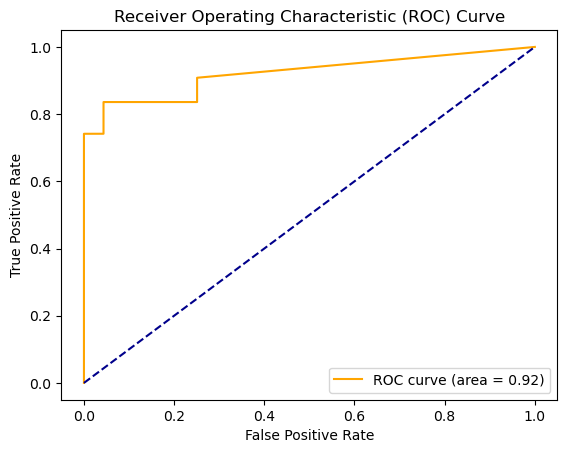

ROC AUC: 0.920


In [25]:
# UPDATED

import numpy as np
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

# Assuming 'results' is your DataFrame and 'distance' is the score to predict conformity

# Inverting the 'distance' scores because higher scores indicate non-conformity
# We invert the scores for ROC AUC calculation because roc_auc_score expects higher values
# to indicate higher likelihood of the positive class
inverted_scores = 1 - results['distance']

# Calculate the ROC curve and AUC using inverted scores
fpr, tpr, thresholds = roc_curve(results['conform'], inverted_scores, pos_label=1)
roc_auc = roc_auc_score(results['conform'], inverted_scores)

# Plot ROC curve
plt.figure()
plt.plot(fpr, tpr, color='orange', label=f'ROC curve (area = {roc_auc:0.2f})')
plt.plot([0, 1], [0, 1], color='darkblue', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

# Print the AUC
print(f"ROC AUC: {roc_auc:.3f}")

# Deviations

### a) identify closest trace

In [26]:
# INPUT TRACE 1



import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("../../data/input_traces/bpic12_trace1.bpmn")

# 3. Convert the BPMN to a Petri net
net, initial_marking, final_marking = pm4py.convert_to_petri_net(bpmn_graph)

aligned_input_trace1 = generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking)

aligning log, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

In [27]:
# INPUT TRACE 2



import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("../../data/input_traces/bpic12_trace2.bpmn")

# 3. Convert the BPMN to a Petri net
net, initial_marking, final_marking = pm4py.convert_to_petri_net(bpmn_graph)

aligned_input_trace2 = generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking)

aligning log, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

In [28]:
# INPUT TRACE 3



import pm4py
from pm4py.objects.log.importer.xes import importer as xes_importer
from pm4py.objects.bpmn.importer import importer as bpmn_importer
from pm4py.algo.conformance.alignments.petri_net import algorithm as alignments_petri

# 2. Import the given BPMN model
bpmn_graph = bpmn_importer.apply("../../data/input_traces/bpic12_trace3.bpmn")

# 3. Convert the BPMN to a Petri net
net, initial_marking, final_marking = pm4py.convert_to_petri_net(bpmn_graph)

aligned_input_trace3 = generate_alignments_adjusted_tracecost_pkl(log, net, initial_marking, final_marking)

aligning log, completed variants ::   0%|          | 0/17 [00:00<?, ?it/s]

In [29]:
# Calculate Euclidean distance
def euclidean_distance(arr1, arr2):
    return np.linalg.norm(arr1 - arr2)

# Prepare a list to store the results
distance = []

# Iterate through each subarray in one_hot_encoding
for subarray in one_hot_encoding:
    dist_to_trace1 = euclidean_distance(subarray, happy_trace1)
    dist_to_trace2 = euclidean_distance(subarray, happy_trace2)
    dist_to_trace3 = euclidean_distance(subarray, happy_trace3)
    
    distances = [dist_to_trace1, dist_to_trace2, dist_to_trace3]
    closest_trace_index = np.argmin(distances)
    closest_trace = f'trace_{closest_trace_index + 1}'
    
    distance.append({
        'Distance to Trace 1': dist_to_trace1,
        'Distance to Trace 2': dist_to_trace2,
        'Distance to Trace 3': dist_to_trace3,
        'Closest Trace': closest_trace
    })

# Create DataFrame
closest_distance = pd.DataFrame(distance)

### b) identify deviations

In [30]:
# Initialize the merged list
aligned_input_trace = []

# Iterate through each row of the fitness dataframe
for index, row in closest_distance.iterrows():
    closest_trace = row['Closest Trace']
    
    # Append the corresponding alignment to the merged list based on the closest trace
    if closest_trace == 'trace_1':
        aligned_input_trace.append(aligned_input_trace1[index])
    elif closest_trace == 'trace_2':
        aligned_input_trace.append(aligned_input_trace2[index])
    elif closest_trace == 'trace_3':
        aligned_input_trace.append(aligned_input_trace3[index])

In [31]:
# Extract fitness values
aligned_traces_fitness = [trace['fitness'] for trace in aligned_traces]
aligned_input_traces_fitness = [trace['fitness'] for trace in aligned_input_trace]

# Create DataFrame
df_fitness = pd.DataFrame({
    'ground_truth_fit': aligned_traces_fitness,
    'predicted_fit': aligned_input_traces_fitness
})

In [32]:
df_fitness

,ground_truth_fit,predicted_fit
0,0.888889,0.736842
1,1.000000,0.736842
2,1.000000,0.736842
3,1.000000,1.000000
4,1.000000,1.000000
...,...,...
13082,0.944444,0.894737
13083,1.000000,1.000000
13084,1.000000,1.000000
13085,0.944444,0.894737


- The logic compares log and model moves in `aligned_traces` and `aligned_input_trace` at each corresponding outer index. It extracts moves from both traces and counts them as detected if they match in both content and presence, regardless of their inner positions within the alignment.

In [33]:
# Find indices where 'predicted' column has value 1
indices_to_keep = results[results['conform'] == 0].index.tolist()

# Filter the lists to keep only the indices where 'predicted' is 1
aligned_input_trace = [aligned_input_trace[i] for i in indices_to_keep]
aligned_traces = [aligned_traces[i] for i in indices_to_keep]

In [34]:
len(aligned_input_trace)

1590

In [35]:
# Function to extract log and model moves excluding (None, >>) and (>>, None)
def extract_moves(alignment):
    log_moves = [move for move in alignment if move[1] == '>>' and move[0] is not None]
    model_moves = [move for move in alignment if move[0] == '>>' and move[1] is not None]
    return log_moves, model_moves

# Initialize counts for moves
total_log_moves = 0
total_no_log_moves = 0
total_model_moves = 0
total_no_model_moves = 0

# Initialize counts for TP, FP, FN, TN
tp_log_moves = 0
fp_log_moves = 0
fn_log_moves = 0
tn_log_moves = 0

tp_model_moves = 0
fp_model_moves = 0
fn_model_moves = 0
tn_model_moves = 0

# Iterate through aligned traces and count moves
for i, aligned_trace in enumerate(aligned_traces):
    log_moves_gt, model_moves_gt = extract_moves(aligned_trace['alignment'])
    total_log_moves += len(log_moves_gt)
    total_no_log_moves += sum(1 for move in aligned_trace['alignment'] if move[1] != '>>' or move[0] is None)
    total_model_moves += len(model_moves_gt)
    total_no_model_moves += sum(1 for move in aligned_trace['alignment'] if move[0] != '>>' or move[1] is None)
    
    if i < len(aligned_input_trace):
        log_moves_input, model_moves_input = extract_moves(aligned_input_trace[i]['alignment'])
        
        # Calculate TP, FP, FN, TN for log moves
        tp_log_moves += sum(1 for move in log_moves_gt if move in log_moves_input)
        fn_log_moves += sum(1 for move in log_moves_gt if move not in log_moves_input)
        fp_log_moves += sum(1 for move in log_moves_input if move not in log_moves_gt)
        tn_log_moves += sum(1 for move in aligned_trace['alignment'] if move not in log_moves_gt and move not in log_moves_input and move[1] != '>>' and move[0] != '>>')
        
        # Calculate TP, FP, FN, TN for model moves
        tp_model_moves += sum(1 for move in model_moves_gt if move in model_moves_input)
        fn_model_moves += sum(1 for move in model_moves_gt if move not in model_moves_input)
        fp_model_moves += sum(1 for move in model_moves_input if move not in model_moves_gt)
        tn_model_moves += sum(1 for move in aligned_trace['alignment'] if move not in model_moves_gt and move not in model_moves_input and move[1] != '>>' and move[0] != '>>')

# Calculate recall, precision, F1 score for log moves
recall_log_moves = tp_log_moves / (tp_log_moves + fn_log_moves) if (tp_log_moves + fn_log_moves) > 0 else 0
precision_log_moves = tp_log_moves / (tp_log_moves + fp_log_moves) if (tp_log_moves + fp_log_moves) > 0 else 0
f1_score_log_moves = 2 * (precision_log_moves * recall_log_moves) / (precision_log_moves + recall_log_moves) if (precision_log_moves + recall_log_moves) > 0 else 0

# Calculate recall, precision, F1 score for model moves
recall_model_moves = tp_model_moves / (tp_model_moves + fn_model_moves) if (tp_model_moves + fn_model_moves) > 0 else 0
precision_model_moves = tp_model_moves / (tp_model_moves + fp_model_moves) if (tp_model_moves + fp_model_moves) > 0 else 0
f1_score_model_moves = 2 * (precision_model_moves * recall_model_moves) / (precision_model_moves + recall_model_moves) if (precision_model_moves + recall_model_moves) > 0 else 0

# Calculate dataset balance for log moves
log_move_percentage = (total_log_moves / (total_log_moves + total_no_log_moves)) * 100 if (total_log_moves + total_no_log_moves) > 0 else 0
no_log_move_percentage = (total_no_log_moves / (total_log_moves + total_no_log_moves)) * 100 if (total_log_moves + total_no_log_moves) > 0 else 0

# Calculate dataset balance for model moves
model_move_percentage = (total_model_moves / (total_model_moves + total_no_model_moves)) * 100 if (total_model_moves + total_no_model_moves) > 0 else 0
no_model_move_percentage = (total_no_model_moves / (total_model_moves + total_no_model_moves)) * 100 if (total_model_moves + total_no_model_moves) > 0 else 0

# Print results for log moves
print(f"Log Moves: TP={tp_log_moves}, FP={fp_log_moves}, FN={fn_log_moves}, TN={tn_log_moves}")
print(f"Precision (Log Moves): {precision_log_moves:.4f}")
print(f"Recall (Log Moves): {recall_log_moves:.4f}")
print(f"F1 Score (Log Moves): {f1_score_log_moves:.4f}")
print(f"Log Move Percentage: {log_move_percentage:.2f}%")
print(f"No Log Move Percentage: {no_log_move_percentage:.2f}%")
print("")

# Print results for model moves
print(f"Model Moves: TP={tp_model_moves}, FP={fp_model_moves}, FN={fn_model_moves}, TN={tn_model_moves}")
print(f"Precision (Model Moves): {precision_model_moves:.4f}")
print(f"Recall (Model Moves): {recall_model_moves:.4f}")
print(f"F1 Score (Model Moves): {f1_score_model_moves:.4f}")
print(f"Model Move Percentage: {model_move_percentage:.2f}%")
print(f"No Model Move Percentage: {no_model_move_percentage:.2f}%")

Log Moves: TP=1191, FP=5418, FN=0, TN=10191
Precision (Log Moves): 0.1802
Recall (Log Moves): 1.0000
F1 Score (Log Moves): 0.3054
Log Move Percentage: 7.20%
No Log Move Percentage: 92.80%

Model Moves: TP=0, FP=1731, FN=1590, TN=10191
Precision (Model Moves): 0.0000
Recall (Model Moves): 0.0000
F1 Score (Model Moves): 0.0000
Model Move Percentage: 9.61%
No Model Move Percentage: 90.39%


In [36]:
# Filter the other dataframe using the indices_to_keep
df_fitness = df_fitness.loc[indices_to_keep]

In [37]:
df_fitness

,ground_truth_fit,predicted_fit
0,0.888889,0.736842
14,0.888889,0.736842
17,0.888889,0.736842
21,0.888889,0.736842
35,0.888889,0.736842
...,...,...
13078,0.944444,0.894737
13079,0.944444,0.894737
13080,0.944444,0.894737
13082,0.944444,0.894737


In [38]:
from sklearn.metrics import mean_squared_error

# Calculate MSE
mse = mean_squared_error(df_fitness['ground_truth_fit'], df_fitness['predicted_fit'])

# Print the MSE restricted to 4 decimal places
print(f"The Mean Squared Error (MSE) is: {mse:.4f}")

The Mean Squared Error (MSE) is: 0.0182
